# 11-year NANOGrav Stochastic Background Analysis

**Note:** Any changes made in a docker container will be lost when that container is removed, and will not appear if a new container is started.  To make persistent changes to this file copy it to the `local_data/` directory and work from there.

## Overview
In this notebook we will give several examples of how to reproduce the results from the 11-year NANOGrav stochastic background analysis paper.

All models are pre-defined in `models/` with names corresponding to those in Table 1 of the paper. All models and priors are exactly as described in the text and Table 2 of the paper.

We will make use of the [`PTMCMCSampler`](https://github.com/jellis18/PTMCMCSampler) package; however, the model functions return a `PTA` that has `get_lnlikelihood` and `get_lnprior` methods that can be used in any sampler that reads in a likelihood and prior function.

In [1]:
from __future__ import (absolute_import, division,
                        print_function, unicode_literals)
import numpy as np
from numpy import log
import matplotlib.pyplot as plt

from utils import get_pulsars, PostProcessing, bayes_fac
from models import models
# from models.optimal_statistic import OptimalStatistic

# from omegagw_funcs import fpbh_sol, log10
from numpy import log10
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Cannot import PINT? Meh...
Do not have acor package


In [2]:
import utils as ut

## Initialize pulsars

In this step we use the convienience function `get_pulsars` to read in the 34 pulsars used in the NANOGrav analysis. This can take several minutes as the data sets are quite large.

This returns a list of `enterprise` `Pulsar` objects that will be used in setting up our PTA in the next step.

By default this will use the 34 pulsars from the NANOGrav analysis and DE436 ephemeris but you can pass keyword arguments `psrlist` (a list of pulsar names to use in the analysis) and `ephem` (a string such as 'DE436') for the ephemeris version.

The `get_pulsars` function has a keyword argument `use_cache` that will cache the list of pulsar objects to a file for the given pulsar list (order does not matter) and ephemeris. When called again, the function will look for the cached file and use that if it exists. This will save on run time.

In [3]:
# psrs = get_pulsars_ipta()
psrs = get_pulsars()

Reading pulsars from cached file.



## Setup the model for upper limit run

In this step we set up the model. All of these models follow the naming convention in Table 2 of the paper.

All models (other than `model_1`, which is for single pulsar noise analyses) have the following arguments:

* **psrs**: A list of pulsar objects that we created in the step above
* **psd**: The PSD to use for the common signals. The three choices are `powerlaw`, `turnover`, or `spectrum` following the description of section 3.2 in the text. `powerlaw` is the default choice
* **gamma_common**: The fixed spectral index value (i.e. 13/3 for SMBHB backgrounds). By default this is set to `None` and the spectral index will vary as a free parameter.
* **upper_limit**: Specifies whether or not we are performing an upper limit. If so, we will use *uniform* priors on the red noise and common red noise amplitudes, otherwise we use *log-uniform* priors
* **bayesephem**: Specifies whether or not to use the dynamical ephemeris model described in the text.

Below we run Model 2A which contains a common red noise signal modeled as a powerlaw with fixed spectral index 13/3. We will include Bayesian ephemeris modeling and compute the upper limit on the common red process.

In [4]:
pta = models.modelSMBH(psrs, bayesephem=True, upper_limit=True)

INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GASP_efac to 1.05973
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GUPPI_efac to 1.0789
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GASP_efac to 1.09248
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GUPPI_efac to 1.16668
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GASP_log10_equad to -7.56152
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GUPPI_log10_equad to -7.78181
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GASP_log10_equad to -8.32139
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GUPPI_log10_equad to -6.67344
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GASP_log10_ecorr to -6.98265
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr1_2_GUPPI_log10_ecorr to -6.76697
INFO: enterprise.signals.signal_base: Setting J0613-0200_Rcvr_800_GASP_log10_ecorr t

## Setup the sampler

We initialize the sampler the likelihood and prior function
from the PTA object. We set up an initial jump covariance matrix
with fairly small jumps as this will be adapted as the MCMC runs.

We will setup an output directory in `outdir` that will contain
the chain (first n columns are the samples for the n parameters 
and last 4 are log-posterior, log-likelihood, acceptance rate, and
an indicator variable for parallel tempering but it doesn't matter
because we aren't using parallel tempering).

We also output text files with the parameter labels and parameter priors
in the same order as the chain output. 

We then add several custom jump proposals to the mix based on
whether or not certain parameters are in the model. These are
all either draws from the prior distribution of parameters or
draws from uniform distributions.

In [5]:
kappaNames = ["kappa_SL", "kappa_ST", "kappa_TT", "kappa_VL"]
names = pta.param_names
kappaIndex = [names.index(name) for name in kappaNames]
kappaIndex.sort()
kappaNames = [pta.param_names[i] for i in kappaIndex]

names.remove(kappaNames[1])
names.remove(kappaNames[2])
names.remove(kappaNames[3])
param_names = names

In [6]:
names = list(ut.get_global_parameters(pta)[0])
names.remove(kappaNames[1])
names.remove(kappaNames[2])
names.remove(kappaNames[3])
names = np.array(names)
# get global and individual parameters
gpars = names
ipars = ut.get_global_parameters(pta)[1]

In [7]:
ndim = len(param_names)
groups  = [range(0, ndim)]
params = param_names

if any(gpars):
    groups.extend([[params.index(gp) for gp in gpars]])

for sc in pta._signalcollections:
    for signal in sc._signals:
        ind = [params.index(p) for p in signal.param_names if (p not in gpars and p not in kappaNames)]
        if ind:
            groups.extend([ind])

[range(0, 20),
 [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 [1, 0],
 [3, 2]]

In [8]:
def newx(x1):
    x2 = np.insert(x1, kappaIndex[1], x1[kappaIndex[0]])
    x3 = np.insert(x2, kappaIndex[2], x1[kappaIndex[0]])
    x4 = np.insert(x3, kappaIndex[3], x1[kappaIndex[0]])
    return x4

In [9]:
def get_lnlikelihood(x1):
    return pta.get_lnlikelihood(newx(x1))

In [10]:
def get_lnprior(x1):
    return pta.get_lnprior(newx(x1)) + 3 * log(x1[kappaIndex[0]])

In [11]:
params = pta.params
params.pop(kappaIndex[3]-5)
params.pop(kappaIndex[2]-5)
params.pop(kappaIndex[1]-5)
params

[J0613-0200_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J0613-0200_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11),
 J1600-3053_red_noise_gamma:Uniform(pmin=0, pmax=7),
 J1600-3053_red_noise_log10_A:LinearExp(pmin=-20, pmax=-11),
 d_jupiter_mass:Normal(mu=0, sigma=1.5497669e-11),
 d_neptune_mass:Normal(mu=0, sigma=7.96103855e-11),
 d_saturn_mass:Normal(mu=0, sigma=8.17306184e-12),
 d_uranus_mass:Normal(mu=0, sigma=5.71923361e-11),
 frame_drift_rate:Uniform(pmin=-1e-09, pmax=1e-09),
 jup_orb_elements:Uniform(pmin=-0.05, pmax=0.05)[6],
 kappa_SL:Uniform(pmin=0, pmax=10),
 log10_A_SL:LinearExp(pmin=-30, pmax=-13),
 log10_A_ST:LinearExp(pmin=-30, pmax=-13),
 log10_A_TT:LinearExp(pmin=-30, pmax=-13),
 log10_A_VL:LinearExp(pmin=-30, pmax=-13)]

In [12]:
x0 = np.hstack(p.sample() for p in params)
get_lnprior(x0)

/home/bear/opt/miniconda3/envs/PTAPolar3/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


118.66620862222508

In [14]:
class JumpProposal(object):

    def __init__(self):
        """Set up some custom jump proposals"""
        self.params = params
        self.pnames = param_names
        self.npar = len(params)
        self.ndim = sum(p.size or 1 for p in params)

        # parameter map
        self.pmap = {}
        ct = 0
        for p in params:
            size = p.size or 1
            self.pmap[p] = slice(ct, ct+size)
            ct += size

        # parameter indices map
        self.pimap = {}
        for ct, p in enumerate(param_names):
            self.pimap[p] = ct

        self.snames = {}
        for sc in pta._signalcollections:
            for signal in sc._signals:
                self.snames[signal.signal_name] = signal.params

    def draw_from_prior(self, x, iter, beta):
        """Prior draw.

        The function signature is specific to PTMCMCSampler.
        """

        q = x.copy()
        lqxy = 0

        # randomly choose parameter
        idx = np.random.randint(0, self.npar)

        # if vector parameter jump in random component
        param = self.params[idx]
        if param.size:
            idx2 = np.random.randint(0, param.size)
            q[self.pmap[param]][idx2] = param.sample()[idx2]

        # scalar parameter
        else:
            q[idx] = param.sample()

        # forward-backward jump probability
        lqxy = param.get_logpdf(x[self.pmap[param]]) - param.get_logpdf(q[self.pmap[param]])

        return q, float(lqxy)

    def draw_from_gwb_prior(self, x, iter, beta):

        q = x.copy()
        lqxy = 0

        signal_name = 'red noise'

        # draw parameter from signal model
        param = np.random.choice(self.snames[signal_name])
        if param.size:
            idx2 = np.random.randint(0, param.size)
            q[self.pmap[param]][idx2] = param.sample()[idx2]

        # scalar parameter
        else:
            q[self.pmap[param]] = param.sample()

        # forward-backward jump probability
        lqxy = param.get_logpdf(x[self.pmap[param]]) - param.get_logpdf(q[self.pmap[param]])

        return q, float(lqxy)

    def draw_from_gwb_log_uniform_distribution(self, x, iter, beta):

        q = x.copy()
        lqxy = 0

        # draw parameter from signal model
        idx = self.pnames.index('log10_A_TT')
        q[idx] = np.random.uniform(-30, -13)
        
        # draw parameter from signal model
        idx = self.pnames.index('log10_A_ST')
        q[idx] = np.random.uniform(-30, -13)
        
        # draw parameter from signal model
        idx = self.pnames.index('log10_A_SL')
        q[idx] = np.random.uniform(-30, -13)
        
        # draw parameter from signal model
        idx = self.pnames.index('log10_A_VL')
        q[idx] = np.random.uniform(-30, -13)

        return q, 0

#     def draw_from_dipole_log_uniform_distribution(self, x, iter, beta):

#         q = x.copy()
#         lqxy = 0

#         # draw parameter from signal model
#         idx = self.pnames.index('log10_A_dipole')
#         q[idx] = np.random.uniform(-18, -11)

#         return q, 0

#     def draw_from_monopole_log_uniform_distribution(self, x, iter, beta):

#         q = x.copy()
#         lqxy = 0

#         # draw parameter from signal model
#         idx = self.pnames.index('log10_A_monopole')
#         q[idx] = np.random.uniform(-18, -11)

#         return q, 0

    def draw_from_ephem_prior(self, x, iter, beta):

        q = x.copy()
        lqxy = 0

        signal_name = 'phys_ephem'

        # draw parameter from signal model
        param = np.random.choice(self.snames[signal_name])
        if param.size:
            idx2 = np.random.randint(0, param.size)
            q[self.pmap[param]][idx2] = param.sample()[idx2]

        # scalar parameter
        else:
            q[self.pmap[param]] = param.sample()

        # forward-backward jump probability
        lqxy = param.get_logpdf(x[self.pmap[param]]) - param.get_logpdf(q[self.pmap[param]])

        return q, float(lqxy)

In [16]:
def setup_sampler(outdir='chains', resume=False):
    # dimension of parameter space
    ndim = len(param_names)

    # initial jump covariance matrix
    cov = np.diag(np.ones(ndim) * 0.1**2)

    sampler = ut.ptmcmc(ndim, get_lnlikelihood, get_lnprior, cov, groups=groups,
                     outDir=outdir, resume=resume)
    np.savetxt(outdir+'/pars.txt',
               list(map(str, param_names)), fmt='%s')
    np.savetxt(outdir+'/priors.txt',
               list(map(lambda x: str(x.__repr__()), params)), fmt='%s')

    # additional jump proposals
    jp = JumpProposal()

    # always add draw from prior
    sampler.addProposalToCycle(jp.draw_from_prior, 5)

    # Ephemeris prior draw
    if 'd_jupiter_mass' in param_names:
        print('Adding ephemeris model prior draws...\n')
        sampler.addProposalToCycle(jp.draw_from_ephem_prior, 10)

    # GWB uniform distribution draw
    if 'log10_A_TT' in param_names:
        print('Adding GWB uniform distribution draws...\n')
        sampler.addProposalToCycle(jp.draw_from_gwb_log_uniform_distribution, 10)
    return sampler

In [17]:
outdir = "local_data/chains/SMBH/"

sampler = setup_sampler(resume=False, outdir=outdir)

Adding ephemeris model prior draws...

Adding GWB uniform distribution draws...



## Sample!

Now we run the sampler. First we set the number of iterations. For production runs we usually do around 5 million samples. Next we set the initial parameter vector (as that is the form in which the sampler expects the input) by drawing from the prior or our parameters.

In running the sampler itself we are setting various weights for different jumps. This is just a relative weighting of how often we will call these types of jumps. 

In [18]:
# mpbh=1e0
N = int(1e4) # one mega-sample!
x0 = np.hstack(p.sample() for p in params)

/home/bear/opt/miniconda3/envs/PTAPolar3/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
sampler.sample(x0, N, AMweight=25, SCAMweight=40, DEweight=55)

/home/bear/opt/miniconda3/envs/PTAPolar3/lib/python3.6/site-packages/enterprise-1.2.1-py3.6.egg/enterprise/signals/parameter.py:64: RuntimeWarning: divide by zero encountered in log
  logpdf = np.log(self.prior(value, **kwargs))


Finished 10.00 percent in 32.214906 s Acceptance rate = 0.465

/home/bear/opt/miniconda3/envs/PTAPolar3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Finished 90.00 percent in 333.321486 s Acceptance rate = 0.346444
Run Complete


## Analyze output

We read in the chain output and pass it to the PostProcessing class that has some useful plotting methods. Lastly we compute the upper limit on the common red noise process.

900


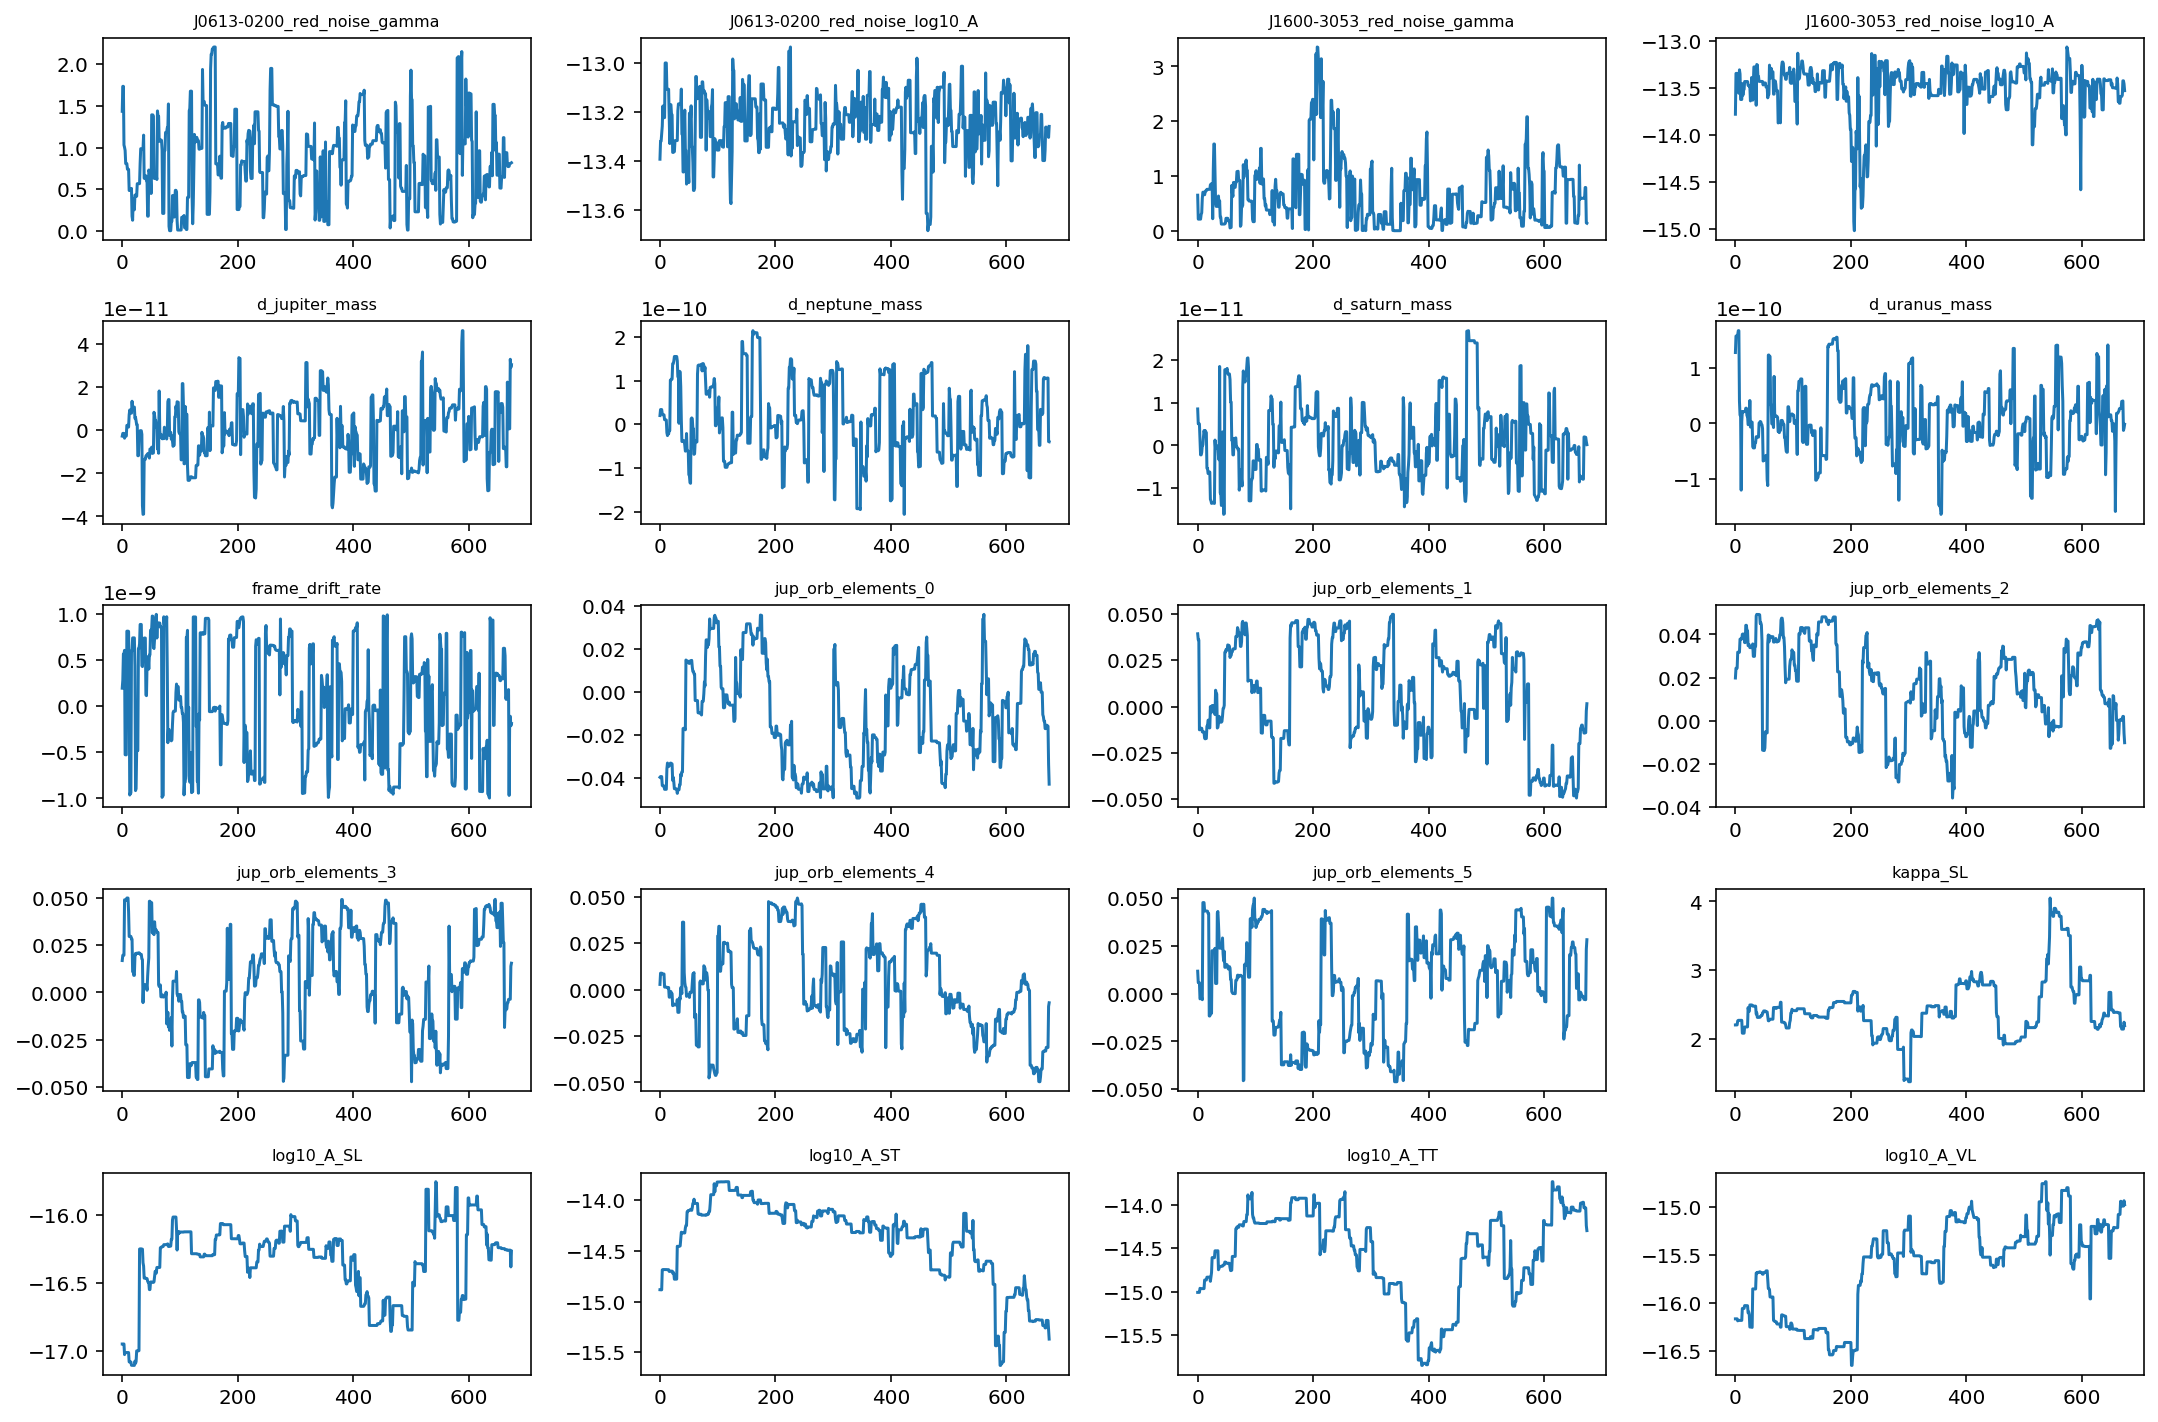

In [23]:
chain = np.loadtxt(outdir + '/chain_1.txt')
pars = np.loadtxt(outdir + '/pars.txt', dtype=np.unicode_)

burn = int(0.1*chain.shape[0])
print(chain.shape[0])

# chain_test = chain[0: 90000]
chain_test = chain
pp = PostProcessing(chain_test, pars)
pp.plot_trace()

-14.968020425004678 1.0764145883262103e-15


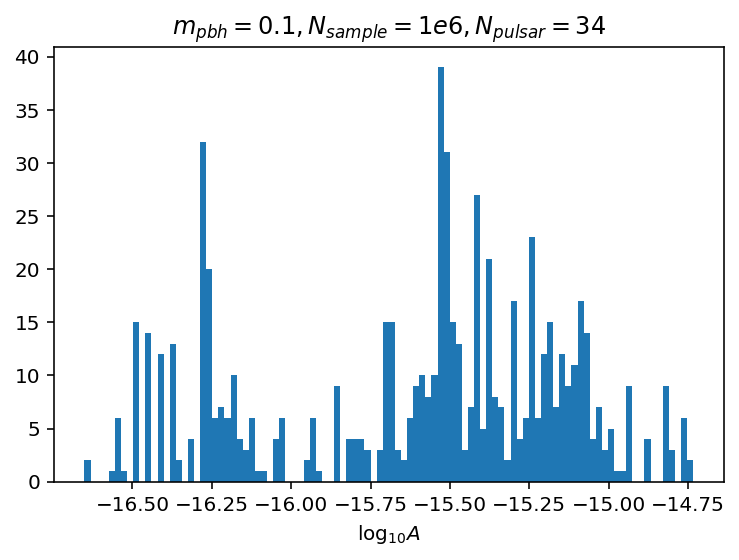

In [24]:
burn = int(4e4)
burn = int(0.25*chain.shape[0])

# mpbh=5, n_sample=1e5

indAgwb = list(pars).index('log10_A_VL')
plt.hist(chain[burn:, indAgwb], 100);
plt.xlabel(r'$\log_{10}A$')
plt.title(r"$m_{pbh} = 0.1, N_{sample}=1e6, N_{pulsar}=34$")
A_chains = chain[burn:, indAgwb]

A95 = 10**np.percentile(A_chains, q=95)
print(log10(A95), A95)
# plt.savefig('logA_m-2_2.pdf')